In [1]:
from viresclient import AeolusRequest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from netCDF4 import Dataset
import pandas as pd
from netCDF4 import num2date


# Aeolus Level 1A product
## Unprocessed Aeolus measurement data

> Abstract: Access to level 1A product and its visualization

## Product information

The Level 1A product of the Aeolus mission contains time-ordered unprocessed detector counts from the atmospheric and internal instrument paths as well as housekeeping information.

**Important:** Access to L1A dataset needs to be requested and is not provided as default. Please contact ESA's EO Help desk if you would like to get access to this product.  

### L1A parameters on VirES

We can print the available parameters for a collection using the *print_available_collections* method.

In [2]:
request = AeolusRequest()
request.print_available_collections(collection="ALD_U_N_1A")

uom  \
field type         identifier                                                               
observation_fields time                                          seconds since 2000-01-01   
                   mie_longitude                                             degrees_east   
                   mie_latitude                                             degrees_north   
                   mie_altitude                                                         m   
                   mie_topocentric_azimuth_of_height_bin                          degrees   
                   mie_topocentric_elevation_of_height_bin                        degrees   
                   mie_target_to_sun_visibility_flag                                    -   
                   mie_range                                                            m   
                   rayleigh_longitude                                        degrees_east   
                   rayleigh_latitude                                        degrees_north   
                   rayleigh_altitude                                                    m   
                   rayleigh_topocentric_azimuth_of_height_bin                     degrees   
                   rayleigh_topocentric_elevation_of_height_bin                   degrees   
                   rayleigh_target_to_sun_visibility_flag                               -   
                   rayleigh_range                                                       m   
                   latitude_of_DEM_intersection                             degrees_north   
                   longitude_of_DEM_intersection                             degrees_east   
                   altitude_of_DEM_intersection                                         m   
                   argument_of_latitude_of_dem_intersection                 degrees_north   
                   sun_elevation_angle                                                deg   
                   velocity_at_DEM_intersection                                       m/s   
                   geoid_separation                                                     m   
                   AOCS_x_position                                                      m   
                   AOCS_y_position                                                      m   
                   AOCS_z_position                                                      m   
                   AOCS_x_velocity                                                    m/s   
                   AOCS_y_velocity                                                    m/s   
                   AOCS_z_velocity                                                    m/s   
                   AOCS_roll_angle                                                degrees   
                   AOCS_pitch_angle                                               degrees   
                   AOCS_yaw_angle                                                 degrees   
                   num_reference_pulses                                                 -   
                   mie_reference_pulse                                                  -   
                   rayleigh_reference_pulse                                             -   
                   instrument_mode                                                      -   
                   number_of_pulses_per_meas                                            -   
                   number_of_meas_per_obs                                               -   
                   average_laser_frequency_offset                                     GHz   
                   average_laser_energy                                                mJ   
                   laser_frequency_offset_std_dev                                     GHz   
                   uv_energy_std_dev                                                   mJ   
                   dt1                                                                 

## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is around **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_1A"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start="2022-08-03T00:00:58Z"
measurement_stop="2022-08-03T01:50:34Z"

# Product parameters to retrieve
# uncomment parameters of interest

# Mie observation level
parameter_mie_observations = [
    "reference_pulse",
    "measurement_data",
    "longitude",
    "latitude",
]

parameter_mie_observations = ["mie_" + param for param in parameter_mie_observations]

# Rayleigh observation level
parameter_rayleigh_observations = [
    "reference_pulse",
    "measurement_data",
    "longitude",
    "latitude"
]

parameter_rayleigh_observations = ["rayleigh_" + param for param in parameter_rayleigh_observations]


parameter_observations_indepdendent = ["time", "num_reference_pulses"]

parameter_list_observations = (
    parameter_rayleigh_observations
    + parameter_mie_observations
    + parameter_observations_indepdendent
)

## Retrieve data from VRE server

In [4]:
# Data request for observation level
# check if observation parameter list is not empty
if len(parameter_list_observations) > 0:

    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set observation fields
    request.set_fields(
        observation_fields=parameter_list_observations,
    )

    # set start and end time and request data
    data_response = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=False
    
    )

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (32.632MB)

In [5]:
ds_observations = data_response.as_xarray()

## Plot data on map

Text(0.5, 1.0, 'Aeolus orbit \n from 2022-08-03T00:00:58Z to 2022-08-03T01:50:34Z')

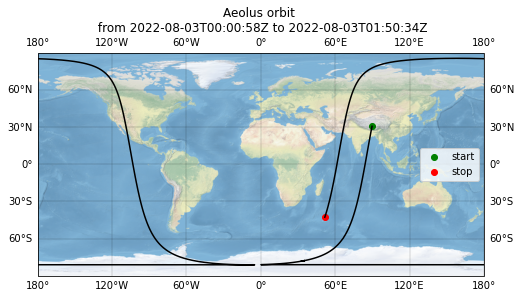

In [6]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
ax.plot(
    ds_observations["rayleigh_longitude"][:, -1],
    ds_observations["rayleigh_latitude"][:, -1],
    "k-",
    transform=ccrs.PlateCarree(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][0, -1],
    ds_observations["rayleigh_latitude"][0, -1],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.PlateCarree(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][-1, -1],
    ds_observations["rayleigh_latitude"][-1, -1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.PlateCarree(),
)
ax.legend()
ax.set_title("Aeolus orbit \n from {} to {}".format(measurement_start, measurement_stop))

## Plot ACCD counts at pixel level

The following example allows to visualize the raw ACCD counts of the atmospheric path for selected pixels. The data is averaged over the measurements of the observations.

In [7]:
# select channel and pixel coordinate (counting starts at zero)

channel = 'rayleigh'
pixel = [0, 15]

if not channel in ('mie', 'rayleigh'):
    raise Exception('Invalid channel selection. Allowed values are "mie" or "rayleigh"')

if not 0 <= pixel[0] <= 24:
    raise Exception('Invalid pixel selection. Allowed range for the pixel row is from 0 to 24.')

if not 0 <= pixel[1] <= 15:
    raise Exception('Invalid pixel selection. Allowed range for the pixel column is from 0 to 15.')


# extract data
pixel_data = ds_observations[channel + '_measurement_data'][:, :, pixel[0], pixel[1]].data.mean(axis=1)
time = num2date(
    ds_observations["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False
)


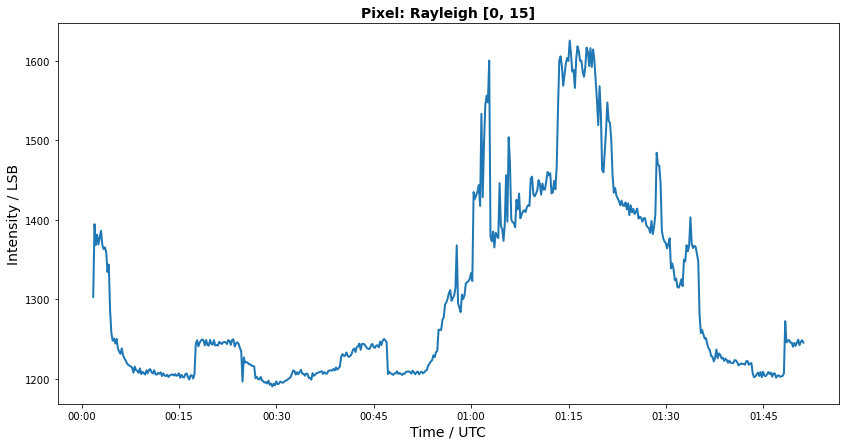

In [8]:
fig = plt.figure(figsize=(14, 7))
ax = plt.subplot()
ax.plot(time, pixel_data, linewidth=2.0)
ax.set_title('Pixel: ' + channel.capitalize() + ' ' + str(pixel), fontsize=14, fontweight='bold')
ax.set_xlabel('Time / UTC', fontsize=14)
ax.set_ylabel('Intensity / LSB', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

## Visualize reference pulse data

The following example demonstrates how to analyse reference pulse data by visualizing the standard deviation of the sunmmed up reference signal counts per observation.


In [9]:
# select channel 
channel = 'rayleigh'

if not channel in ('mie', 'rayleigh'):
    raise Exception('Invalid channel selection. Allowed values are "mie" or "rayleigh"')
    

# extract data
num_ref_pulse = ds_observations["num_reference_pulses"][:].data[0]
ref_pulse_std = ds_observations[channel + '_reference_pulse'][:, :num_ref_pulse, 2:18].data.sum(axis=2).std(axis=1)

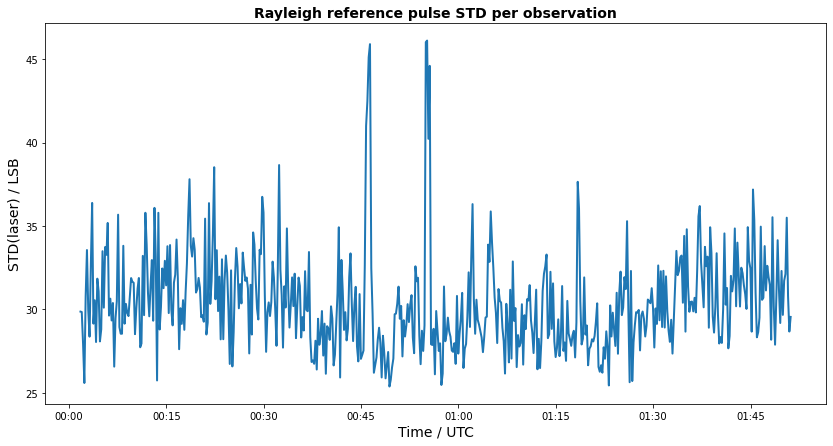

In [10]:
fig = plt.figure(figsize=(14, 7))
ax = plt.subplot()
ax.plot(time, ref_pulse_std, linewidth=2.0)
ax.set_title(channel.capitalize() + ' reference pulse STD per observation', fontsize=14, fontweight='bold')
ax.set_xlabel('Time / UTC', fontsize=14)
ax.set_ylabel('STD(laser) / LSB', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))